In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


In [2]:
df = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = df.select_dtypes(include=['number']).columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


이상치 있을 수 있을 수 있음 
person_income, age 쪽 

In [3]:
#정규화 X 범주형 데이터 변환 X

# 범주형 변수를 'category' 타입으로 변환
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df[categorical_features] = df[categorical_features].astype('category')

# XGBoost 모델 훈련 시 enable_categorical=True 설정
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
#정규화만 진행
X = df[numerical_features].drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train_final, y_test_final = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 범주형 변수를 'category' 타입으로 변환
categorical_data  = df[categorical_features].astype('category')

# 숫자형 데이터 정규화된 결과를 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# 정규화된 숫자형 데이터에 범주형 데이터 병합
X_train_final = pd.concat([X_train_scaled_df, categorical_data.loc[X_train.index]], axis=1)
X_test_final = pd.concat([X_test_scaled_df, categorical_data.loc[X_test.index]], axis=1)

In [5]:
# 범주형 처리 추가 / 정규화 X 
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
df_encoded

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
# 범주형 처리 추가 / 정규화 O
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
df_encoded

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression

In [7]:
# 로지스틱 회귀 모델 훈련
model = LogisticRegression(max_iter=100)
model.fit(X_train_scaled, y_train_scaled)

# 예측 및 성능 평가
y_pred = model.predict(X_test_scaled)
print("F1-score (Logistic Regression):", f1_score(y_test_scaled, y_pred))
print(classification_report(y_test_scaled, y_pred))

F1-score (Logistic Regression): 0.6246001744693225
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12613
           1       0.77      0.52      0.62      2049

    accuracy                           0.91     14662
   macro avg       0.85      0.75      0.79     14662
weighted avg       0.91      0.91      0.90     14662



RandomForestRegressor

In [31]:
# RF 해보기
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_encoded, y_train_encoded)
y_pred = rf.predict(X_test_encoded)
print("F1-score (RF):", f1_score(y_test_encoded, y_pred.round()))

F1-score (RF): 0.8049180327868852


In [34]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_scaled, y_train_scaled)
y_pred = rf.predict(X_test_scaled)
print("F1-score (RF):", f1_score(y_test_scaled, y_pred.round()))

F1-score (RF): 0.8043537414965987


SVM

In [60]:
from sklearn.svm import SVC

df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# 스케일링 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)
print("F1-score (SVM):", f1_score(y_test, y_pred_svm))

F1-score (SVM): 0.7654879773691655


In [20]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12613
           1       0.91      0.66      0.77      2049

    accuracy                           0.94     14662
   macro avg       0.93      0.82      0.87     14662
weighted avg       0.94      0.94      0.94     14662



Gradient Boosting

In [27]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True, random_state=55)
xgb_model.fit(X_train_origin, y_train_origin)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_origin)
print("F1-score (XGBoost):", f1_score(y_test_origin, y_pred))
#print(classification_report(y_test_origin, y_pred))

F1-score (XGBoost): 0.8135411069317571


In [26]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=55)
xgb_model.fit(X_train_scaled, y_train_scaled)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_scaled)
print("F1-score (XGBoost):", f1_score(y_test_scaled, y_pred))

F1-score (XGBoost): 0.8117267348036579


In [29]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True, random_state=55)
xgb_model.fit(X_train_final, y_train_final)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_final)
print("F1-score (XGBoost):", f1_score(y_test_final, y_pred))
print(classification_report(y_test_final, y_pred))

F1-score (XGBoost): 0.8135411069317571
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12613
           1       0.90      0.74      0.81      2049

    accuracy                           0.95     14662
   macro avg       0.93      0.86      0.89     14662
weighted avg       0.95      0.95      0.95     14662



In [24]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss' , enable_categorical=True, random_state=55)
xgb_model.fit(X_train_encoded, y_train_encoded)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_encoded)
print("F1-score (XGBoost):", f1_score(y_test_encoded, y_pred))

F1-score (XGBoost): 0.8117267348036579


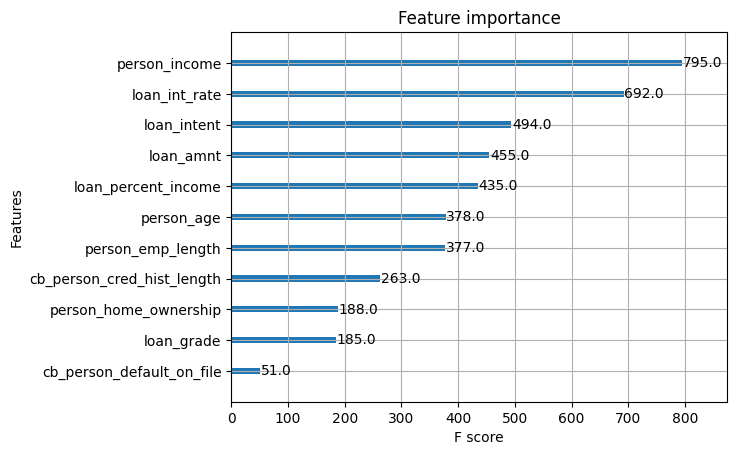

In [30]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# 특성 중요도 시각화
plot_importance(xgb_model)
plt.show()

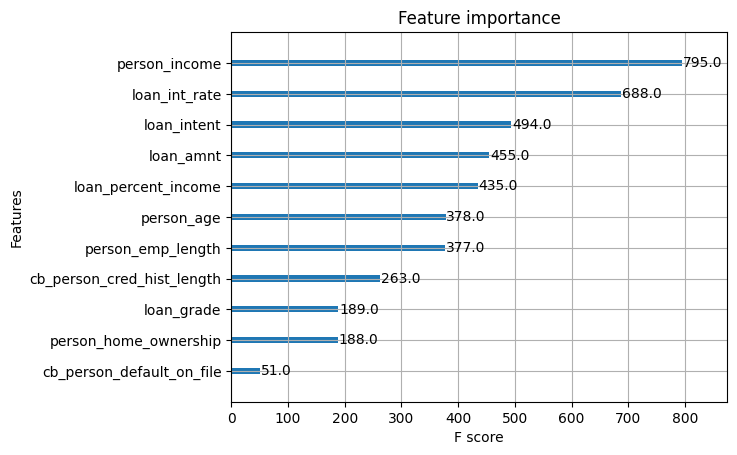

In [28]:
# 특성 중요도 시각화
plot_importance(xgb_model)
plt.show()

In [10]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(eval_metric='Logloss', cat_features=categorical_features, random_state=55)
catboost_model.fit(X_train_origin, y_train_origin)

# 예측 및 평가
y_pred = catboost_model.predict(X_test_origin)
print("F1-score (CatBoost):", f1_score(y_test_origin, y_pred))

Learning rate set to 0.051834
0:	learn: 0.6289605	total: 58.5ms	remaining: 58.4s
1:	learn: 0.5733736	total: 115ms	remaining: 57.3s
2:	learn: 0.5258076	total: 172ms	remaining: 57.3s
3:	learn: 0.4850897	total: 251ms	remaining: 1m 2s
4:	learn: 0.4498900	total: 312ms	remaining: 1m 2s
5:	learn: 0.4207607	total: 367ms	remaining: 1m
6:	learn: 0.3953345	total: 425ms	remaining: 1m
7:	learn: 0.3736232	total: 475ms	remaining: 58.8s
8:	learn: 0.3542082	total: 544ms	remaining: 59.8s
9:	learn: 0.3344814	total: 600ms	remaining: 59.4s
10:	learn: 0.3178180	total: 653ms	remaining: 58.7s
11:	learn: 0.3027090	total: 708ms	remaining: 58.3s
12:	learn: 0.2889899	total: 761ms	remaining: 57.8s
13:	learn: 0.2776867	total: 812ms	remaining: 57.2s
14:	learn: 0.2679225	total: 861ms	remaining: 56.5s
15:	learn: 0.2595236	total: 913ms	remaining: 56.1s
16:	learn: 0.2520066	total: 964ms	remaining: 55.8s
17:	learn: 0.2446732	total: 1.02s	remaining: 55.7s
18:	learn: 0.2391626	total: 1.08s	remaining: 55.7s
19:	learn: 0.233

In [8]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(eval_metric='Logloss', cat_features=categorical_features, random_state=55)
catboost_model.fit(X_train_final, y_train_final)

# 예측 및 평가
y_pred = catboost_model.predict(X_test_final)
print("F1-score (CatBoost):", f1_score(y_test_final, y_pred))

Learning rate set to 0.051834
0:	learn: 0.6289605	total: 201ms	remaining: 3m 21s
1:	learn: 0.5733736	total: 258ms	remaining: 2m 8s
2:	learn: 0.5258076	total: 321ms	remaining: 1m 46s
3:	learn: 0.4850897	total: 379ms	remaining: 1m 34s
4:	learn: 0.4498900	total: 437ms	remaining: 1m 26s
5:	learn: 0.4207607	total: 489ms	remaining: 1m 21s
6:	learn: 0.3953345	total: 557ms	remaining: 1m 19s
7:	learn: 0.3736232	total: 603ms	remaining: 1m 14s
8:	learn: 0.3542082	total: 657ms	remaining: 1m 12s
9:	learn: 0.3344814	total: 712ms	remaining: 1m 10s
10:	learn: 0.3178180	total: 765ms	remaining: 1m 8s
11:	learn: 0.3027090	total: 819ms	remaining: 1m 7s
12:	learn: 0.2889899	total: 874ms	remaining: 1m 6s
13:	learn: 0.2776867	total: 926ms	remaining: 1m 5s
14:	learn: 0.2679225	total: 977ms	remaining: 1m 4s
15:	learn: 0.2595236	total: 1.03s	remaining: 1m 3s
16:	learn: 0.2520066	total: 1.08s	remaining: 1m 2s
17:	learn: 0.2446732	total: 1.14s	remaining: 1m 2s
18:	learn: 0.2391626	total: 1.19s	remaining: 1m 1s
19

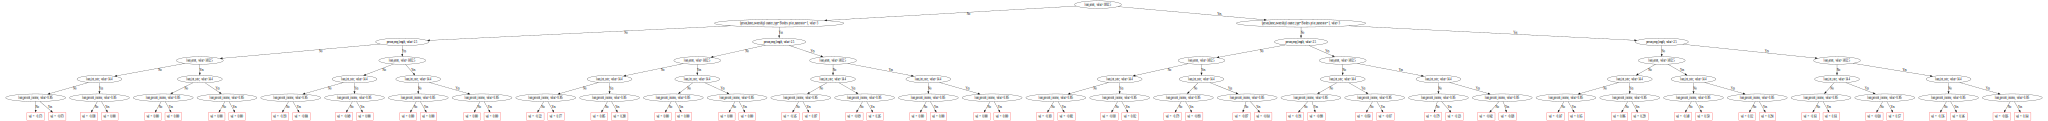

In [14]:
# 특성 중요도 시각화
from catboost import Pool

is_cat = (X_train_final.dtypes == 'category')
cat_features_index = np.where(is_cat)[0] 

# 트리 시각화
catboost_model.plot_tree(tree_idx=0, pool=Pool(X_train_final, y_train_final, cat_features=cat_features_index, feature_names=list(X_train_final.columns)))

In [9]:
test_encoded = pd.get_dummies(test, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
test_encoded_scaled = scaler.fit_transform(test_encoded)